In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw_data = pd.read_csv('train_preprocess.csv', sep=';')
raw_data.dtypes

Location           object
MinTemp           float64
MaxTemp           float64
Rainfall          float64
Evaporation       float64
Sunshine          float64
WindGustDir        object
WindGustSpeed     float64
WindDir9am         object
WindDir3pm         object
WindSpeed9am      float64
WindSpeed3pm      float64
Humidity9am       float64
Humidity3pm       float64
Pressure9am       float64
Pressure3pm       float64
Cloud9am          float64
Cloud3pm          float64
Temp9am           float64
Temp3pm           float64
RainTomorrow         bool
Year                int64
Month               int64
Day                 int64
WindSpeedDelta    float64
WindDirChange        bool
HumidityDelta     float64
PressureDelta     float64
CloudDelta        float64
TempDelta         float64
dtype: object

In [3]:
y = raw_data.RainTomorrow
raw_data.drop('RainTomorrow', axis=1, inplace=True)

In [7]:
categorical_cols = [cat for cat in raw_data.columns if raw_data[cat].dtype == 'O']
numerical_cols = list(set(raw_data.columns.values.tolist()) - set(categorical_cols))

In [9]:
numeric_means = raw_data[numerical_cols].mean()
X_real_mean = raw_data[numerical_cols].fillna(numeric_means)
X_real_zeros = raw_data[numerical_cols].fillna(0)
X_cat = raw_data[categorical_cols].fillna('NaN')

In [12]:
from sklearn.feature_extraction import DictVectorizer as DV

encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.astype('str').T.to_dict().values())

In [39]:
X_cat_oh

(70240, 81)

In [14]:
X_cat.shape

(70240, 4)

In [22]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.2, 
                                     random_state=0,
                                    stratify=y)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.2, 
                                      random_state=0,
                                     stratify=y)
(X_train_cat_oh, 
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                      test_size=0.2, 
                                      random_state=0,
                                     stratify=y)

# train_data = raw_data.iloc[:-1000, :]
# hold_out_test_data = raw_data.iloc[-1000:, :]

best zero {'C': 0.5}
test score zero 0.8562350896532321


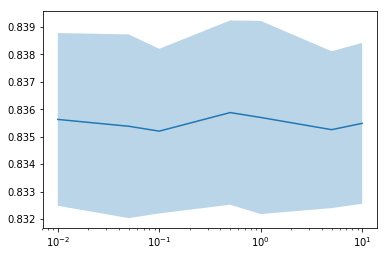

best mean {'C': 0.1}
test score mean 0.8657392392414482


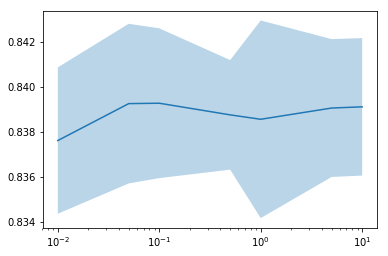

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

estimator = LogisticRegression(solver='liblinear')
optimizer_zero = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_zero.fit(np.hstack((X_train_real_zeros, X_train_cat_oh)), y_train)
print("best zero", optimizer_zero.best_params_)
auc1 = roc_auc_score(y_test, optimizer_zero.predict_proba(np.hstack((X_test_real_zeros, X_test_cat_oh)))[:, 1])
print("test score zero " + str(auc1))
plot_scores(optimizer_zero)
estimator = LogisticRegression(solver='liblinear')
optimizer_mean = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_mean.fit(np.hstack((X_train_real_mean, X_train_cat_oh)), y_train)
print("best mean", optimizer_mean.best_params_)
auc2 = roc_auc_score(y_test, optimizer_mean.predict_proba(np.hstack((X_test_real_mean, X_test_cat_oh)))[:, 1])
print("test score mean " + str(auc2))
plot_scores(optimizer_mean)

In [24]:
from sklearn.preprocessing import StandardScaler
scaler_zero = StandardScaler()
X_train_real_zero_scaled = scaler_zero.fit_transform(X_train_real_zeros)
X_test_real_zero_scaled = scaler_zero.transform(X_test_real_zeros)
scaler_mean = StandardScaler()
X_train_real_mean_scaled = scaler_mean.fit_transform(X_train_real_mean)
X_test_real_mean_scaled = scaler_mean.transform(X_test_real_mean)

best zero {'C': 5}
test score zero 0.8563607299037893


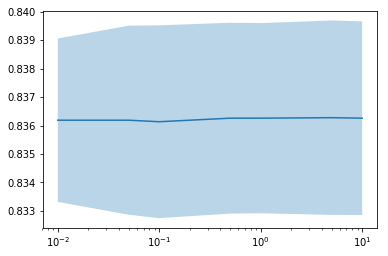

best mean {'C': 0.1}
test score mean 0.8662456161533723


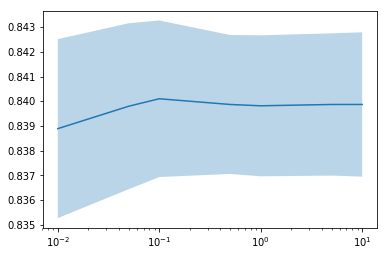

In [25]:
estimator = LogisticRegression(solver='liblinear', class_weight='balanced')
optimizer_zero = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_zero.fit(np.hstack((X_train_real_zero_scaled, X_train_cat_oh)), y_train)
print("best zero", optimizer_zero.best_params_)
auc1 = roc_auc_score(y_test, optimizer_zero.predict_proba(np.hstack((X_test_real_zero_scaled, X_test_cat_oh)))[:, 1])
print("test score zero " + str(auc1))
plot_scores(optimizer_zero)
estimator = LogisticRegression(solver='liblinear', class_weight='balanced')
optimizer_mean = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_mean.fit(np.hstack((X_train_real_mean_scaled, X_train_cat_oh)), y_train)
print("best mean", optimizer_mean.best_params_)
auc2 = roc_auc_score(y_test, optimizer_mean.predict_proba(np.hstack((X_test_real_mean_scaled, X_test_cat_oh)))[:, 1])
print("test score mean " + str(auc2))
plot_scores(optimizer_mean)

best zero {'C': 10}
test score zero 0.8568701253711434


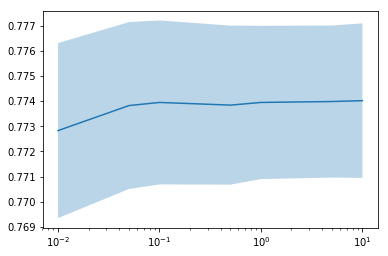

best mean {'C': 5}
test score mean 0.8665948003674094


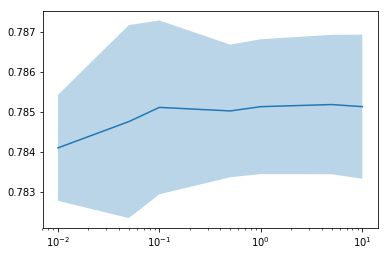

In [28]:
estimator = LogisticRegression(solver='liblinear', class_weight='balanced')
optimizer_zero = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_zero.fit(np.hstack((X_train_real_zero_scaled, X_train_cat_oh)), y_train)
print("best zero", optimizer_zero.best_params_)
auc1 = roc_auc_score(y_test, optimizer_zero.predict_proba(np.hstack((X_test_real_zero_scaled, X_test_cat_oh)))[:, 1])
print("test score zero " + str(auc1))
plot_scores(optimizer_zero)
estimator = LogisticRegression(solver='liblinear', class_weight='balanced')
optimizer_mean = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_mean.fit(np.hstack((X_train_real_mean_scaled, X_train_cat_oh)), y_train)
print("best mean", optimizer_mean.best_params_)
auc2 = roc_auc_score(y_test, optimizer_mean.predict_proba(np.hstack((X_test_real_mean_scaled, X_test_cat_oh)))[:, 1])
print("test score mean " + str(auc2))
plot_scores(optimizer_mean)

best {'C': 0.1, 'penalty': 'l1'}
test score0.8668043336773821


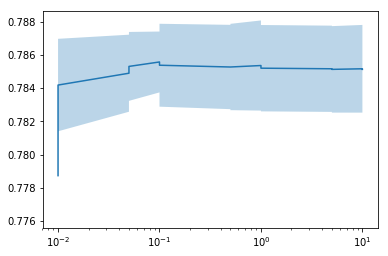

In [32]:
X_train = np.hstack((X_train_real_mean_scaled, X_train_cat_oh))
X_test = np.hstack((X_test_real_mean_scaled, X_test_cat_oh))

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
             'penalty': ['l1', 'l2']}


estimator = LogisticRegression(solver='liblinear', class_weight='balanced')
optimizer_zero = GridSearchCV(estimator, param_grid, cv=5)
optimizer_zero.fit(X_train, y_train)
print("best", optimizer_zero.best_params_)
auc = roc_auc_score(y_test, optimizer_zero.predict_proba(X_test)[:, 1])
print("test score" + str(auc))
plot_scores(optimizer_zero)

In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, optimizer_zero.predict(X_test))

array([[8592, 2203],
       [ 766, 2487]])

In [41]:
ind = [i for i in range(optimizer_zero.best_estimator_.coef_.shape[1]) if optimizer_zero.best_estimator_.coef_[0, i] == 0.0]

In [42]:
ind

[35, 38, 45, 46, 72, 75, 78, 87, 95, 101]

In [40]:
len(numerical_cols)

25

In [45]:
columns = [encoder.feature_names_[i - 25] for i in ind]

In [46]:
columns

['Location=Melbourne',
 'Location=Moree',
 'Location=Portland',
 'Location=Richmond',
 'WindDir9am=E',
 'WindDir9am=N',
 'WindDir9am=NNW',
 'WindDir9am=WNW',
 'WindGustDir=NNW',
 'WindGustDir=SSW']

In [49]:
raw_data.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns'],
      dtype=object)

In [50]:
test_dat = pd.read_csv('test_preprocess.csv', ';')
test_dat.Location.unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns'],
      dtype=object)

In [51]:
test_dat.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Temp3pm,Year,Month,Day,WindSpeedDelta,WindDirChange,HumidityDelta,PressureDelta,CloudDelta,TempDelta
0,Albury,13.6,25.3,0.0,NaN,NaN,SE,48.0,SE,SE,...,23.8,2015,10,27,-9.0,False,-11.0,-2.2,NaN,8.0
1,Albury,6.2,25.5,0.0,NaN,NaN,NE,19.0,ENE,SSW,...,23.6,2015,10,28,5.0,True,-25.0,-5.5,NaN,8.8
2,Albury,9.3,27.9,0.0,NaN,NaN,SE,22.0,ESE,SSE,...,27.2,2015,10,29,6.0,True,-33.0,-3.0,NaN,8.7
3,Albury,9.7,28.1,0.0,NaN,NaN,ENE,28.0,SE,E,...,27.2,2015,10,30,8.0,True,-23.0,-3.9,NaN,9.4
4,Albury,17.1,21.7,5.4,NaN,NaN,ENE,28.0,SE,NE,...,19.2,2015,10,31,4.0,True,-13.0,-2.2,1.0,1.0


In [53]:
test_dat.loc[test_dat.Location == 'Albury'].tail()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Temp3pm,Year,Month,Day,WindSpeedDelta,WindDirChange,HumidityDelta,PressureDelta,CloudDelta,TempDelta
598,Albury,1.2,15.2,0.4,NaN,NaN,ENE,15.0,NaN,NNE,...,14.3,2017,6,21,2.0,True,-38.0,-2.7,NaN,11.4
599,Albury,0.8,13.4,0.0,NaN,NaN,W,17.0,S,NaN,...,13.3,2017,6,22,-6.0,True,-34.0,-3.5,-7.0,9.7
600,Albury,1.1,11.9,0.0,NaN,NaN,SE,44.0,SSE,SSE,...,10.2,2017,6,23,-7.0,False,-19.0,-4.6,-7.0,7.5
601,Albury,1.1,14.1,0.2,NaN,NaN,WSW,28.0,SW,W,...,13.1,2017,6,24,11.0,True,-51.0,-1.6,-1.0,9.2
602,Albury,3.9,10.9,0.0,NaN,NaN,NNW,28.0,S,NaN,...,8.8,2017,6,25,-6.0,True,-6.0,-1.7,1.0,2.4


In [52]:
raw_data.loc[raw_data.Location == 'Albury'].tail()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Temp3pm,Year,Month,Day,WindSpeedDelta,WindDirChange,HumidityDelta,PressureDelta,CloudDelta,TempDelta
2402,Albury,16.6,24.7,1.6,NaN,NaN,NNW,43.0,E,N,...,22.2,2015,10,21,19.0,True,-14.0,-1.3,0.0,1.4
2403,Albury,13.3,25.2,0.8,NaN,NaN,ESE,33.0,SSE,ESE,...,24.4,2015,10,22,0.0,True,-22.0,-1.0,NaN,5.9
2404,Albury,14.1,24.6,0.2,NaN,NaN,N,33.0,SE,NE,...,22.5,2015,10,23,-4.0,True,-18.0,-2.3,0.0,5.6
2405,Albury,10.3,26.6,0.0,NaN,NaN,W,30.0,SE,ESE,...,24.5,2015,10,24,2.0,True,-35.0,-3.3,NaN,7.3
2406,Albury,10.0,30.5,0.0,NaN,NaN,ENE,28.0,ESE,N,...,29.7,2015,10,25,-1.0,True,-47.0,-4.7,NaN,12.0
